In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
sns.set()

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [3]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

### Функция кросс-валидации

In [4]:

def cross_validation(train, features, target):
    msle_list = []
    mse_list = []

    kf = KFold(n_splits=5, shuffle = True)
    for i, (train_index, val_index) in enumerate(kf.split(train)):
        train_part = train.loc[train_index, : ]
        val_part = train.loc[val_index,:  ]

        model = SGDRegressor()
        model.fit( X=train_part[features].fillna(0), y = train_part[target] )
        val_prediction = model.predict( val_part[features].fillna(0) ).clip( 0, 1000000000)


        mse = mean_squared_error(val_prediction,  val_part[target]  )
        msle = mean_squared_log_error(val_prediction,  val_part[target]  )


        msle_list.append(msle)
        mse_list.append(mse)
        print( f'Fold {i}: msle {msle}, mse {mse}')
    
    score = np.mean(msle_list)
    std = np.std(msle_list)
    print( f'MSLE average = {score}, std ={std}')
    
    return score, std

In [5]:
cross_validation(train, features, target)

Fold 0: msle 38.19206415748486, mse 174903965743373.0
Fold 1: msle 142.22128214972108, mse 232659843826120.6
Fold 2: msle 180.15250781083202, mse 2.1826995019740317e+17
Fold 3: msle 130.62271791635558, mse 1338178226465079.8
Fold 4: msle 0.28543040690725635, mse 54949959606386.375
MSLE average = 98.29480048826015, std =67.66607691109415


(98.29480048826015, 67.66607691109415)

### Создание модели

In [6]:
def train_and_save_model(train, test, features, target, nameFile):
    model = SGDRegressor()
    model.fit(X=train[features], y = train[target])
    test_prediction = model.predict(test[features])
    sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
    sample_submission[target] = test_prediction
    sample_submission[target] = sample_submission[target].clip(0, 1000000000)
    sample_submission.to_csv(nameFile + '.csv', index = False)

### Нормализация

In [7]:
def normalize(sequences):
    return (sequences - sequences.mean()) / (sequences.max() - sequences.min())

### Модель №1 
непрерывные признаки с заполненными пропусками
1. metro_km_walk
2. kremlin_km
3. full_sq 

In [8]:
train1 = train.copy()
test1 = test.copy()

In [9]:
features1 = features.copy()

In [10]:
fillna_value_train = {'metro_km_walk': max(train1['metro_km_walk']), 'kremlin_km': max(train1['kremlin_km'])}
train1 = train1.fillna(value=fillna_value_train)
fillna_value_test = {'metro_km_walk': max(test1['metro_km_walk']), 'kremlin_km': max(test1['kremlin_km'])}
test1 = test1.fillna(value=fillna_value_test)
#train['metro_km_walk'].isna().sum()
#train1['metro_km_walk'].isna().sum()

In [11]:
train1[features].isna().sum()
test1[features].isna().sum()

metro_km_walk    0
kremlin_km       0
full_sq          0
dtype: int64

In [12]:
score_cross_val1, _ = cross_validation(train1, features1, target)

Fold 0: msle 103.31119694744109, mse 5.861527890525711e+17
Fold 1: msle 4.0338289581627, mse 242345725111438.06
Fold 2: msle 119.43247703841415, mse 4.575690525512015e+17
Fold 3: msle 9.027772136395749, mse 43391309040786.95
Fold 4: msle 30.73373742758661, mse 71890163393604.38
MSLE average = 53.307802501600065, std =48.52019375594976


In [13]:
train_and_save_model(train1, test1, features1, target, 'model1')

#### Score: 9.9

### Модель №2
Нормирование признаков из первой модели (std=1, mean = 0)

In [14]:
train2 = train1.copy()
test2 = test1.copy()

In [15]:
train2[features] = normalize(train2[features])
test2[features] = normalize(test2[features])
# scaler = StandardScaler()
# train2[features] = scaler.fit_transform(train2[features])

# scaler = StandardScaler()
# test2[features] = scaler.fit_transform(test2[features])

In [16]:
features2 = features.copy()

In [17]:
score_cross_val2, _ = cross_validation(train2, features2, target)

Fold 0: msle 0.3735302312299491, mse 17566038783195.852
Fold 1: msle 0.3677926388215759, mse 20458503654564.793
Fold 2: msle 0.3788254950937285, mse 22329501456588.08
Fold 3: msle 0.3703377467781154, mse 22444200212203.25
Fold 4: msle 0.4206067632260868, mse 19407894047321.1
MSLE average = 0.38221857502989115, std =0.01954438547440308


In [18]:
train_and_save_model(train2, test2, features2, target, 'model2')

#### Score 0.39087

### Модель №3
добавить преобразованные различным образом категориальне признаки:
1. product_type
2. sub_area

In [19]:
train3 = train1.copy()
test3 = test1.copy()

In [20]:
features3 = features.copy() + ['product_type', 'sub_area']

In [21]:
train3['product_type'] = train3['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })
test3['product_type'] = test3['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })

In [22]:
K = train3.groupby(['product_type']).size()
mean_y = train3.groupby(['product_type'])['product_type'].mean()
global_mean_y = train3['product_type'].mean()
train3['product_type'] = (mean_y * K + global_mean_y * 10) / (K + 10)
test3['product_type'] = (mean_y * K + global_mean_y * 10) / (K + 10)

In [23]:
mean_price_by_sub_area = train3.groupby(['sub_area'])[target].mean().astype(int) / 1000
train3['sub_area'] = train3['sub_area'].replace(mean_price_by_sub_area)
test3['sub_area'] = test3['sub_area'].replace(mean_price_by_sub_area)

In [24]:
fillna_value = {'product_type': 0.5}
train3 = train3.fillna(value=fillna_value)
test3 = test3.fillna(value=fillna_value)

In [25]:
fillna_value_train = {'metro_km_walk': max(train3['metro_km_walk']), 'kremlin_km': max(train3['kremlin_km'])}
train3 = train3.fillna(value=fillna_value_train)
fillna_value_test = {'metro_km_walk': max(test3['metro_km_walk']), 'kremlin_km': max(test3['kremlin_km'])}
test3 = test3.fillna(value=fillna_value_test)

In [26]:
train3[features3] = normalize(train3[features3])
test3[features3] = normalize(test3[features3])

In [27]:
score_cross_val3, _ = cross_validation(train3, features3, target)

Fold 0: msle 0.3027978427416605, mse 19684013943503.902
Fold 1: msle 0.3256127358548171, mse 15019891430358.117
Fold 2: msle 0.3239933637752318, mse 16067906801556.146
Fold 3: msle 0.33432728690597063, mse 17786263382734.355
Fold 4: msle 0.3369192711682742, mse 19615595011620.2
MSLE average = 0.32473010008919084, std =0.012025203740816214


In [28]:
train_and_save_model(train3, test3, features3, target, 'model3')

##### Score: 0.40215

### Модель №4
добавить datetime признак

In [29]:
train4 = train2.copy()
test4 = test2.copy()

In [30]:
train4['timestamp'] = pd.to_datetime(train4['timestamp'])
test4['timestamp'] = pd.to_datetime(test4['timestamp'])

In [31]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    output= pd.DataFrame()
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000 
    return output

In [32]:
date_features_train = get_date_time_features(train4['timestamp'])
train4['month_transaction'] = date_features_train['month']
train4['year_transaction'] = date_features_train['year']
train4['seconds_transaction'] = date_features_train['seconds']

date_features_test = get_date_time_features(test4['timestamp'])
test4['month_transaction'] = date_features_test['month']
test4['year_transaction'] = date_features_test['year']
test4['seconds_transaction'] = date_features_test['seconds']

In [33]:
features4 = features2.copy() + ['month_transaction', 'year_transaction', 'seconds_transaction']

In [34]:
train4[features4] = normalize(train4[features4])
test4[features4] = normalize(test4[features4])

In [35]:
score_cross_val4, _ = cross_validation(train4, features4, target)

Fold 0: msle 0.3589973231304849, mse 17588672797275.809
Fold 1: msle 0.3639505662260662, mse 17691183681297.78
Fold 2: msle 0.3545440701743874, mse 23515055974556.184
Fold 3: msle 0.4143336528257962, mse 21513299580810.234
Fold 4: msle 0.37460552077577025, mse 19886167566404.098
MSLE average = 0.373286226626501, std =0.021583454224683753


In [36]:
train_and_save_model(train4, test4, features4, target, 'model4')

#### Score: 0.5

### Модель №5
TODO

In [37]:
analyze_features = [
    'price_doc',
    'timestamp',
    'full_sq',
    'life_sq',
    'floor',
    'max_floor',
    'material',
    'build_year',
    'num_room',
    'kitch_sq',
    'state',
    'product_type',
    'sub_area',
    'price_doc',
    'office_count_1500',
    'cafe_count_1500',
    'metro_km_walk',
    'park_km',
    'workplaces_km',
    'shopping_centers_km',
    'theater_km'
]

In [38]:
train5 = train3.copy()
test5 = test3.copy()

In [39]:
train5['price_per_square'] = train5[target] / train5['full_sq']
analyze_features += ['price_per_square']
train5['floor_div_max'] = train5['floor'] / train5['max_floor']
analyze_features += ['floor_div_max']

<AxesSubplot:>

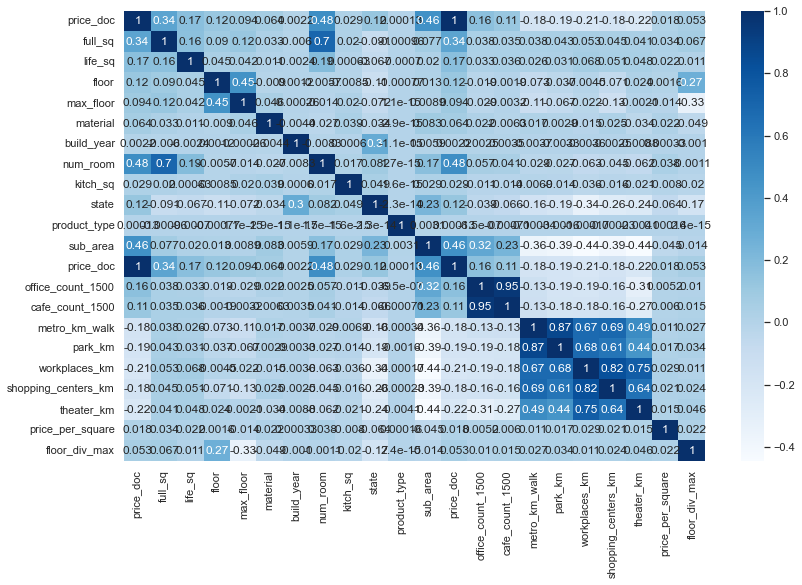

In [40]:
import seaborn as sb
sns.set(rc={'figure.figsize':(13,8.27)}) # https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
corr = train5[analyze_features].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [41]:
features5 = ['full_sq', 'num_room', 'sub_area']

In [42]:
features5 = ['full_sq', 'num_room', 'sub_area', 'life_sq',
            'floor', 'office_count_1500', 'metro_km_walk',
            'park_km', 'workplaces_km', 'shopping_centers_km', 'theater_km'
           ]

In [43]:
fillna_value_train = {'num_room': 1, 'life_sq': train5['full_sq'], 'floor': 1}
train5 = train5.fillna(value=fillna_value_train)
fillna_value_test = {'num_room': 1, 'life_sq': test5['full_sq'], 'floor': 1}
test5 = test5.fillna(value=fillna_value_test)

In [44]:
train5[features5] = normalize(train5[features5])
test5[features5] = normalize(test5[features5])

In [45]:
score_cross_val5, _ = cross_validation(train5, features5, target)

Fold 0: msle 0.28609229632473004, mse 14538172935701.77
Fold 1: msle 0.29179164252963735, mse 16465105820390.193
Fold 2: msle 0.2890486485767706, mse 13914245866455.756
Fold 3: msle 0.29078439862032435, mse 14108413868734.004
Fold 4: msle 0.28500908715419226, mse 14293190663118.893
MSLE average = 0.288545214641131, std =0.0026202171866591705


In [46]:
train_and_save_model(train5, test5, features5, target, 'model5')

#### Score: 1.3

No handles with labels found to put in legend.


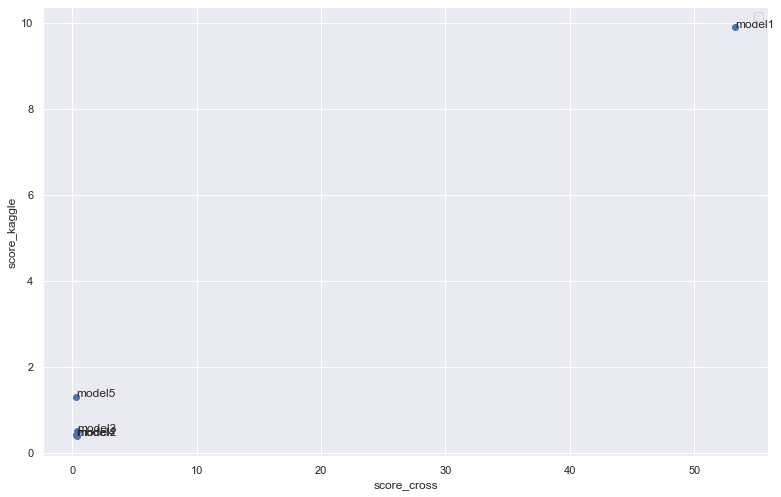

In [50]:
df = pd.DataFrame()
df['score_cross_val'] = [score_cross_val1, score_cross_val2, score_cross_val3, score_cross_val4, score_cross_val5]
df['score_kaggle'] = [9.9, 0.39087, 0.40215, 0.5, 1.3]
df['model'] = ['model1', 'model2', 'model3', 'model4', 'model5']

df.sort_values('score_cross_val', ascending = False, inplace= True)

fig, ax = plt.subplots()
ax.scatter(df['score_cross_val'], df['score_kaggle'])

for i, txt in enumerate(df['model']):
    ax.annotate(txt, (df['score_cross_val'][i], df['score_kaggle'][i]))

# plt.plot(df['score_cross_val'], df['score_kaggle'])
plt.xlabel('score_cross')
plt.ylabel('score_kaggle')
plt.legend()
plt.show()

# Вывод
Самой лучшей моделью оказалась модель №2 с нормированными параметрами  *metro_km_walk, kremlin_km, full_sq*. При добавлении новых параметров в модель score снижался, скорее всего выбранные параметры слишком слабо коррелируют с target'ом. Выведенные параметры *floor_div_max* и *price_per_square* оказались тоже слабо коррелируемыми с price_doc.